In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from matplotlib.lines import Line2D
import numpy as np
import torchvision.utils as vutils
from functools import reduce, partial
import matplotlib.pyplot as plt

In [245]:
def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)

def activity_square(vector):
    n = len(vector)
    side = int(np.sqrt(n))
    if side ** 2 < n:
        side += 1
    square = torch.zeros(side ** 2)
    square[:n] = vector
    return square.view(side, side)

def _plot_grad_flow(named_parameters):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                if p.grad is None:
                    print("%s missing grad" % n)
                else:
                    ave_grads.append(p.grad.abs().mean())
                    max_grads.append(p.grad.abs().max())
        plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
        plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(left=0, right=len(ave_grads))
        plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.legend([Line2D([0], [0], color="c", lw=4),
                    Line2D([0], [0], color="b", lw=4),
                    Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [354]:
import rsm_samplers
import rsm
import util
reload(rsm)
reload(rsm_samplers)
reload(util)

from torch.utils.data import DataLoader, BatchSampler

dataset = rsm_samplers.MNISTBufferedDataset("~/nta/datasets", download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]),)

VISUAL = False
DEBUG = False

ALL_CELLS = True

predict_memory = None # 'column'

if VISUAL or DEBUG:
    MAX_BATCHES = 5
    EPOCHS = 5
    bs = 1
    plot_interval = 5
else:
    MAX_BATCHES = 10
    EPOCHS = 40
    bs=32
    plot_interval = 5

SEQ = [[0,1,2,3],[0,3,2,1]]
sl = 8
d_in = 28 ** 2
gamma = 0.0  # Inh decay
eps = 0.0  # Memory decay
d_out = tc if predict_memory else d_in
dropout_p = 0.0
pred_gain = 1.0
boost_strength = 3.0

if ALL_CELLS:
    m = 1000
    n = 1
    k = 25
    k_winner_cells = 1    
else:
    m=200
    n=6
    k=50
    k_winner_cells=2
    
tc = m * n    

sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, 
                                            batch_size=bs,
                                            noise_buffer=True,
                                            randomize_sequences=True, 
                                            random_mnist_images=True)

loader = DataLoader(dataset,
             batch_sampler=sampler,
             collate_fn=rsm_samplers.pred_sequence_collate)
model = rsm.RSMLayer(d_in=d_in, d_out=d_out, m=m, n=n, k=k, eps=eps, gamma=gamma, 
                     k_winner_cells=k_winner_cells, bsz=bs,
                     boost_strat='col_boosting', # 'rsm_inhibition', 
                     pred_gain=pred_gain,
                     dropout_p=dropout_p,
                     x_b_norm=False,
                     boost_strength=boost_strength,
                     mask_shifted_pi=False,
                     debug_log_names=['x_a_batch'], #['pred_output', 'x_b', 'x_b_last'],
                     visual_debug=VISUAL, debug=DEBUG)

criterion = MSELoss()

LR = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

0 loss 1.1958841562271119 x_b (mean) 0.02499745413661003


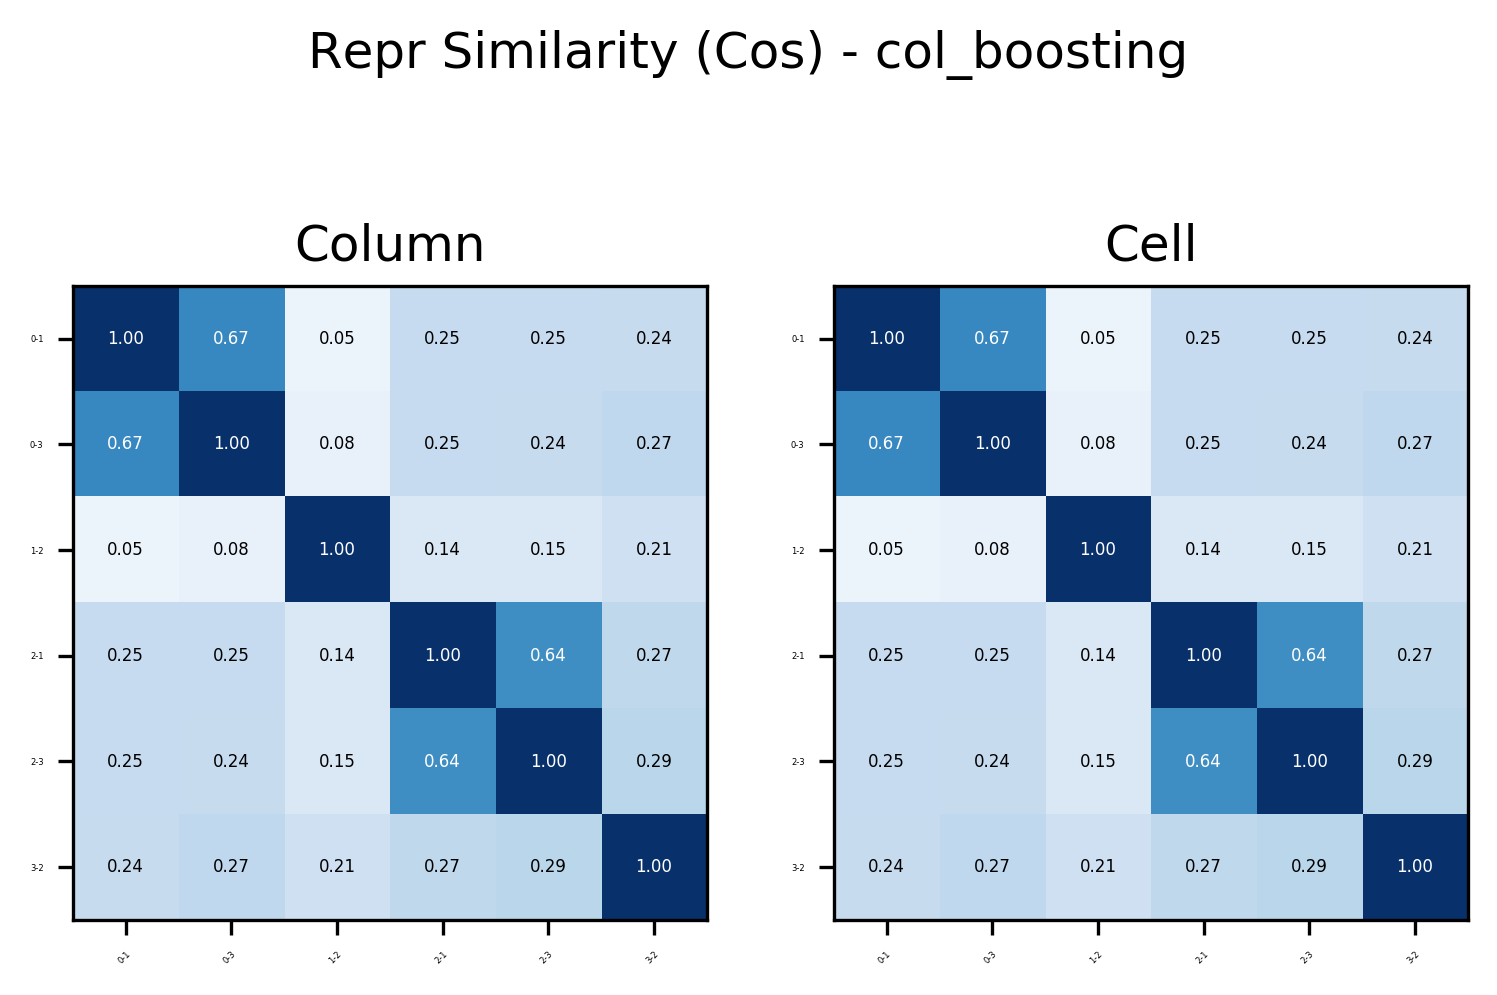

5 loss 0.8836192071437836 x_b (mean) 0.02498019114136696


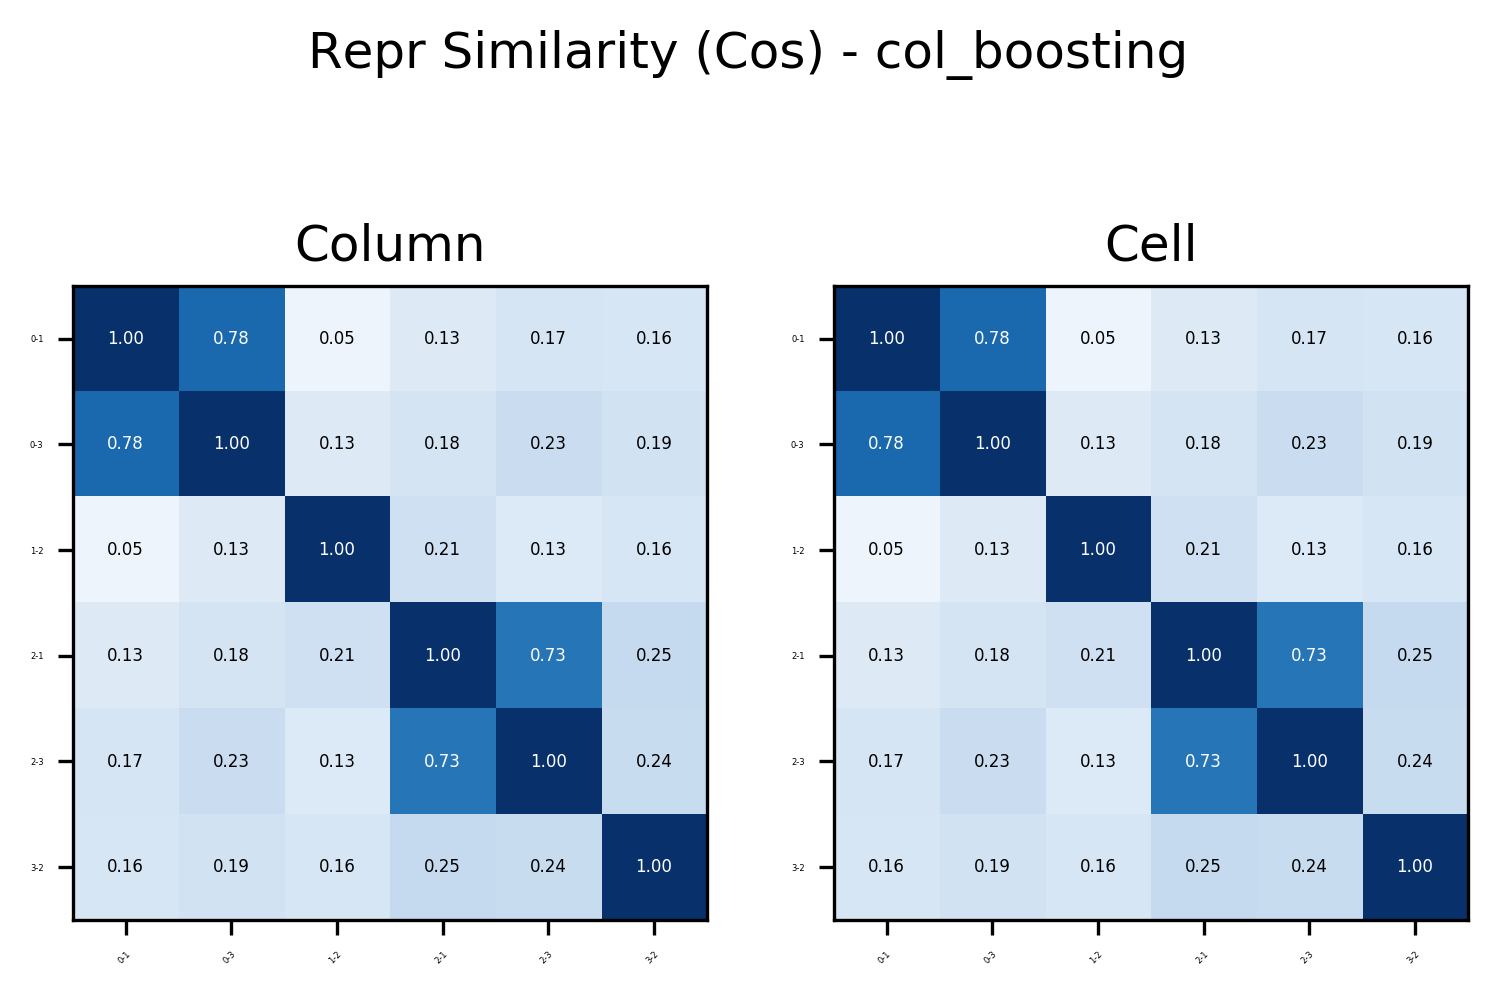

10 loss 0.8703210115432739 x_b (mean) 0.024952832609415054


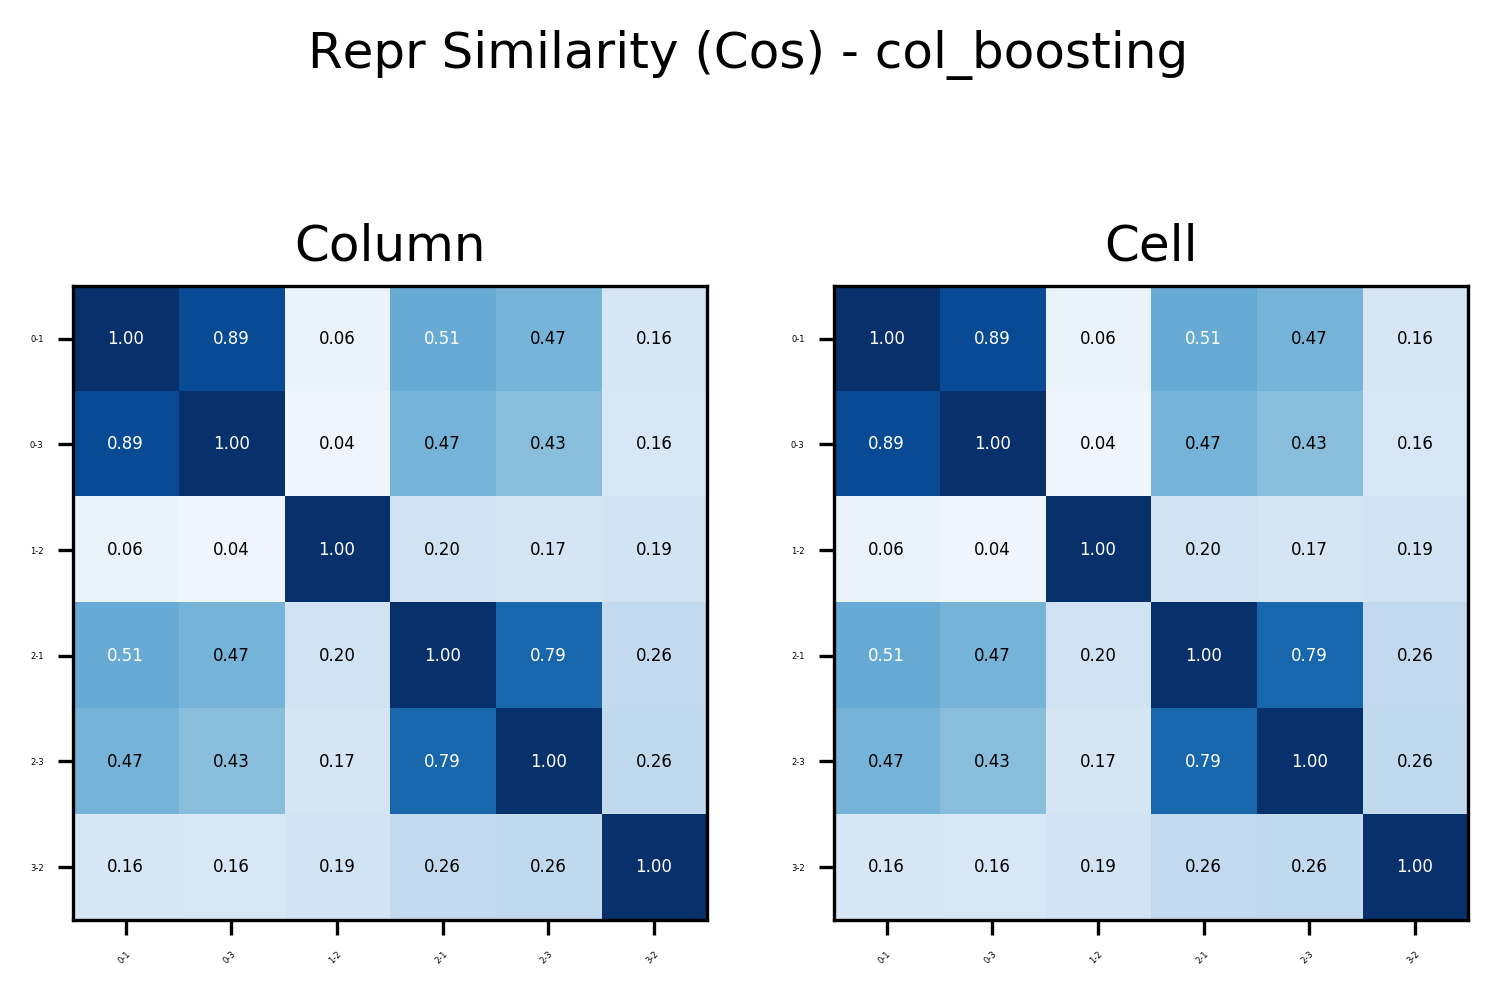

15 loss 0.8747760415077209 x_b (mean) 0.024884000420570374


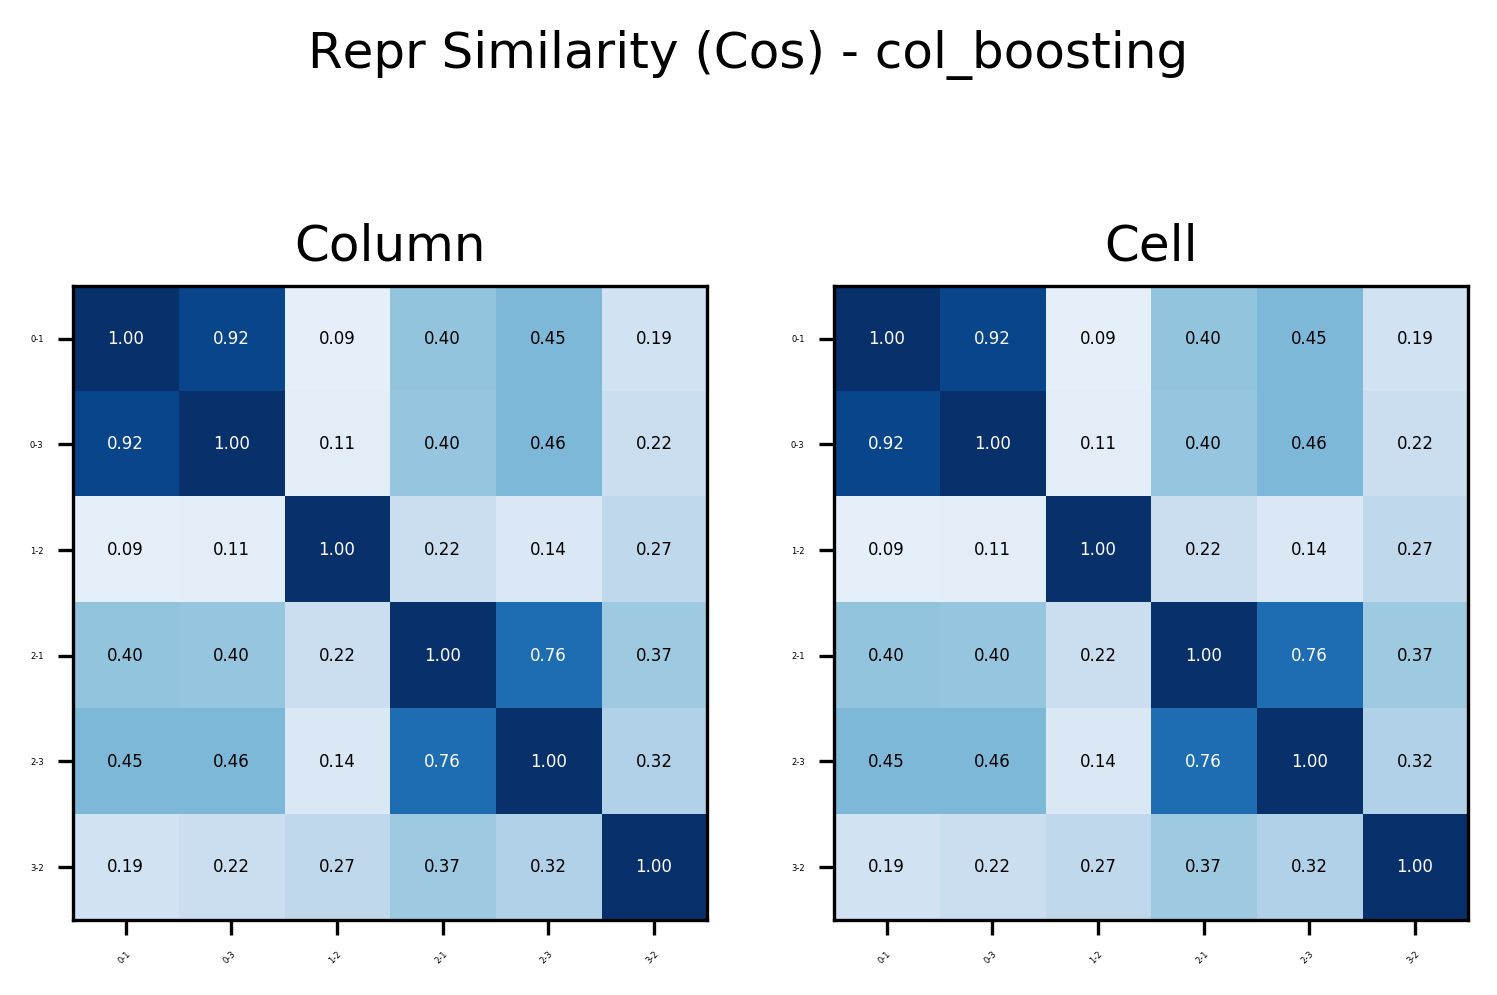

20 loss 0.8725124299526215 x_b (mean) 0.024925395846366882


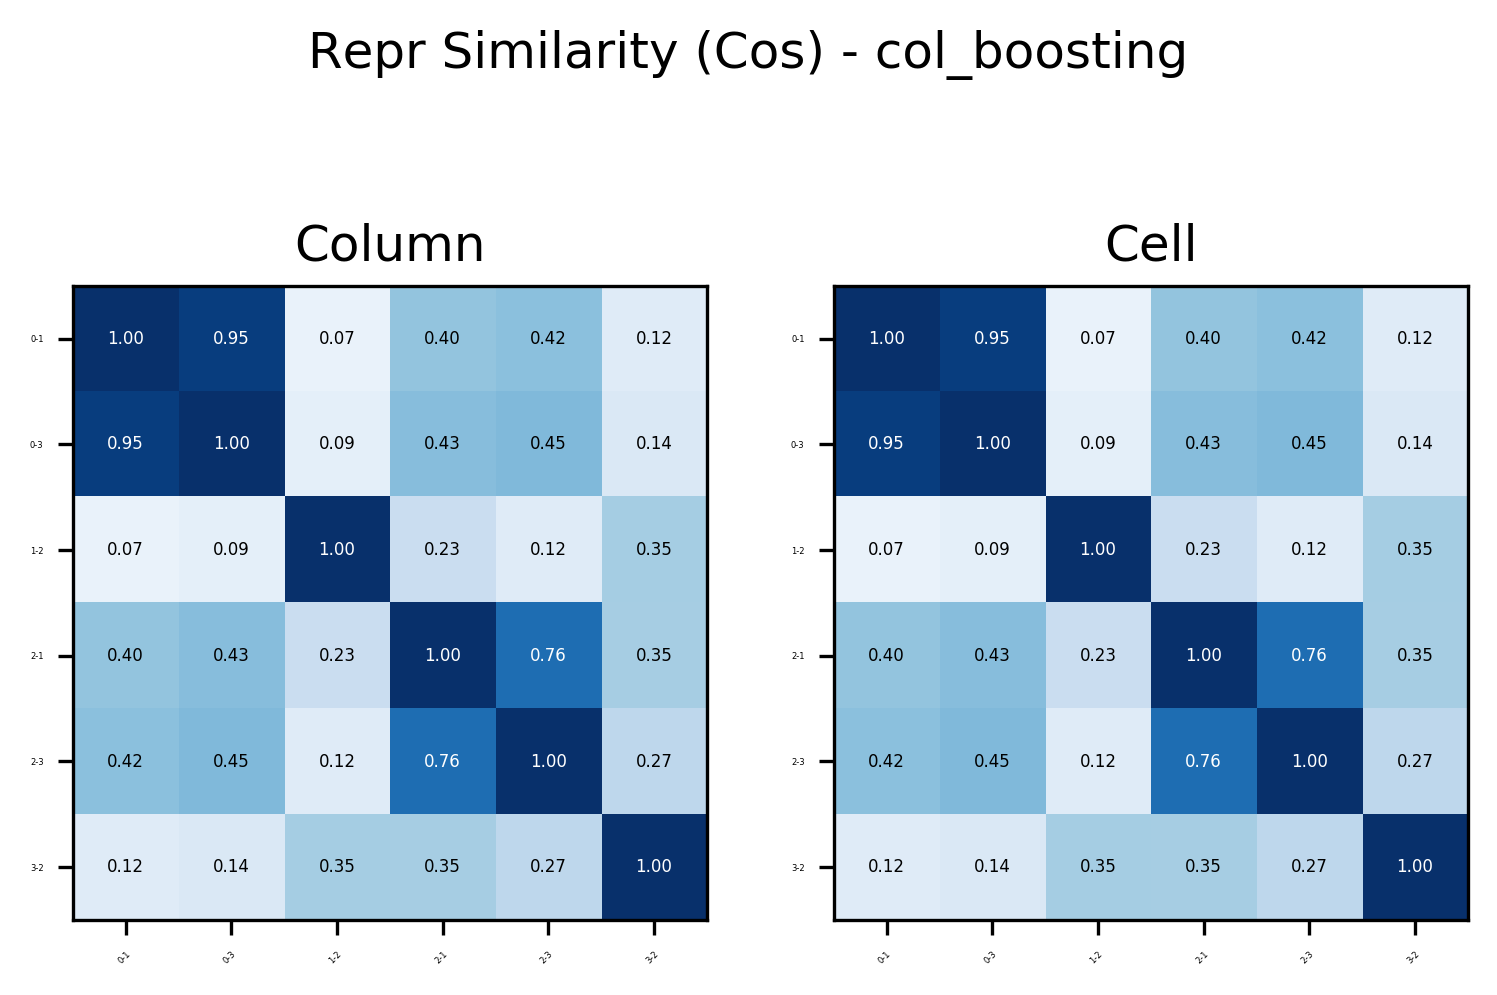

25 loss 0.894603157043457 x_b (mean) 0.024738814681768417


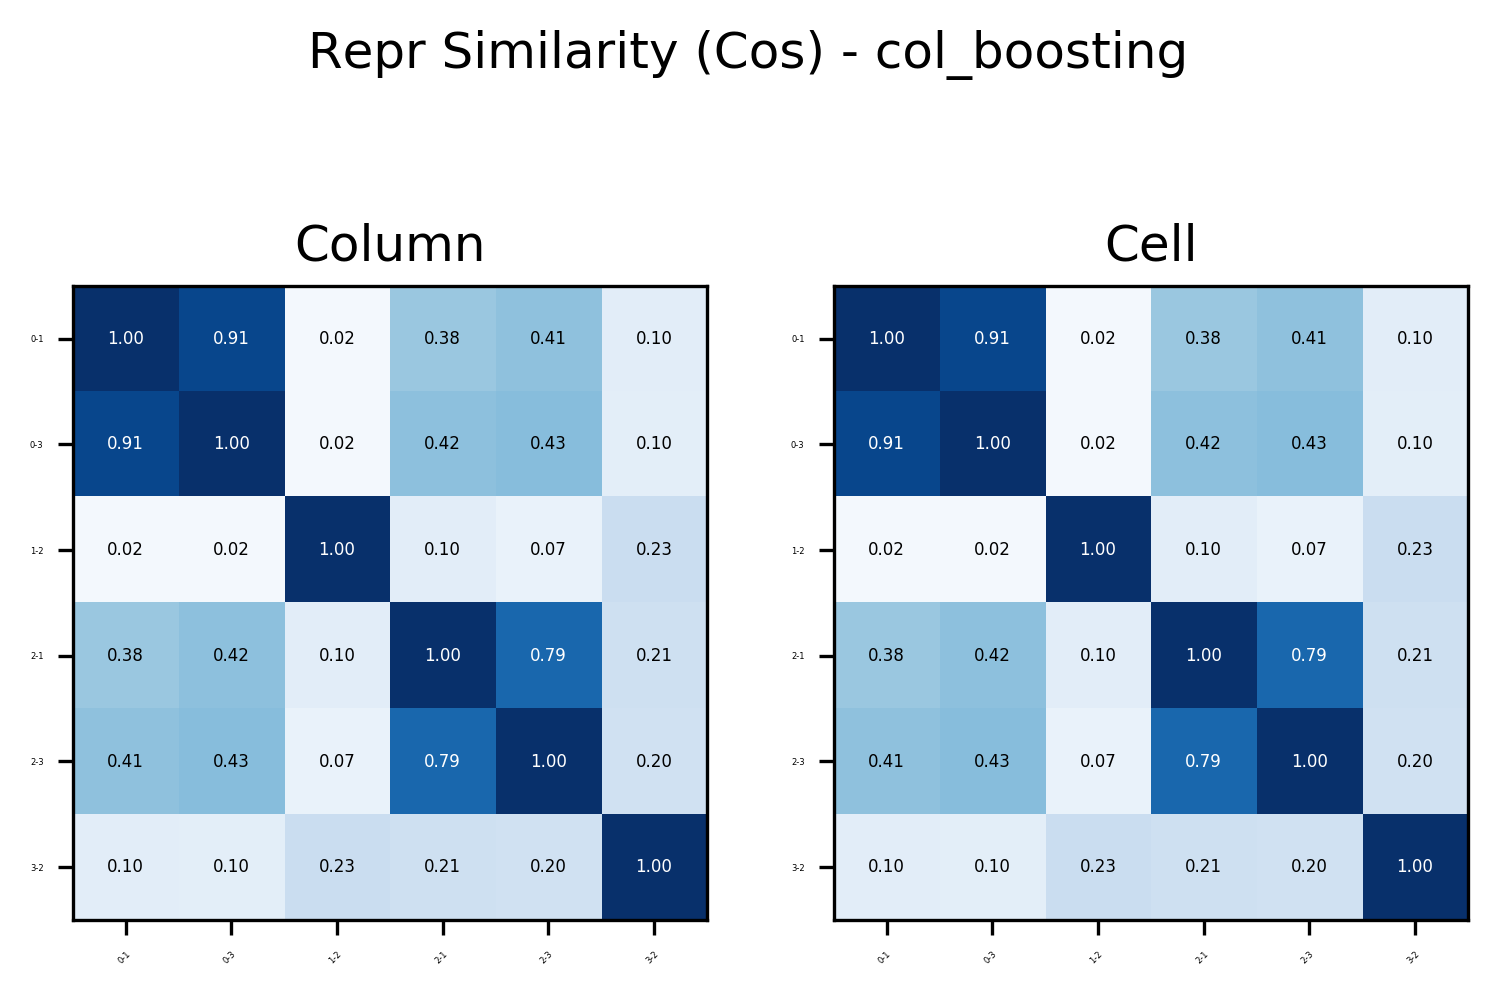

30 loss 0.8771757304668426 x_b (mean) 0.024828119203448296


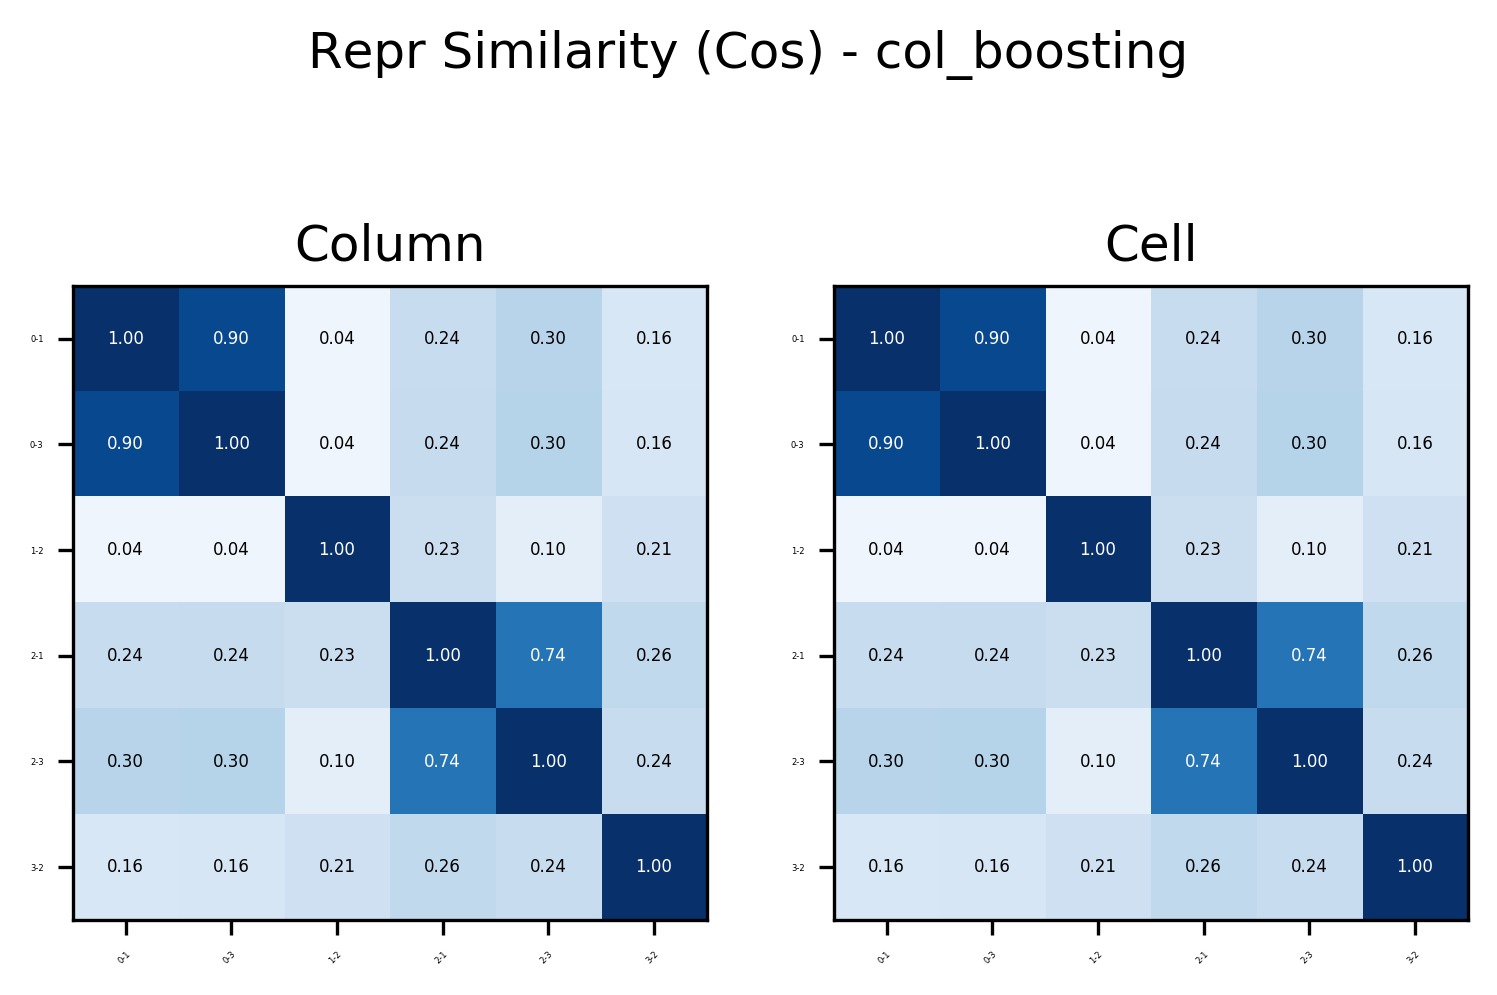

35 loss 0.8910473585128784 x_b (mean) 0.024767884984612465


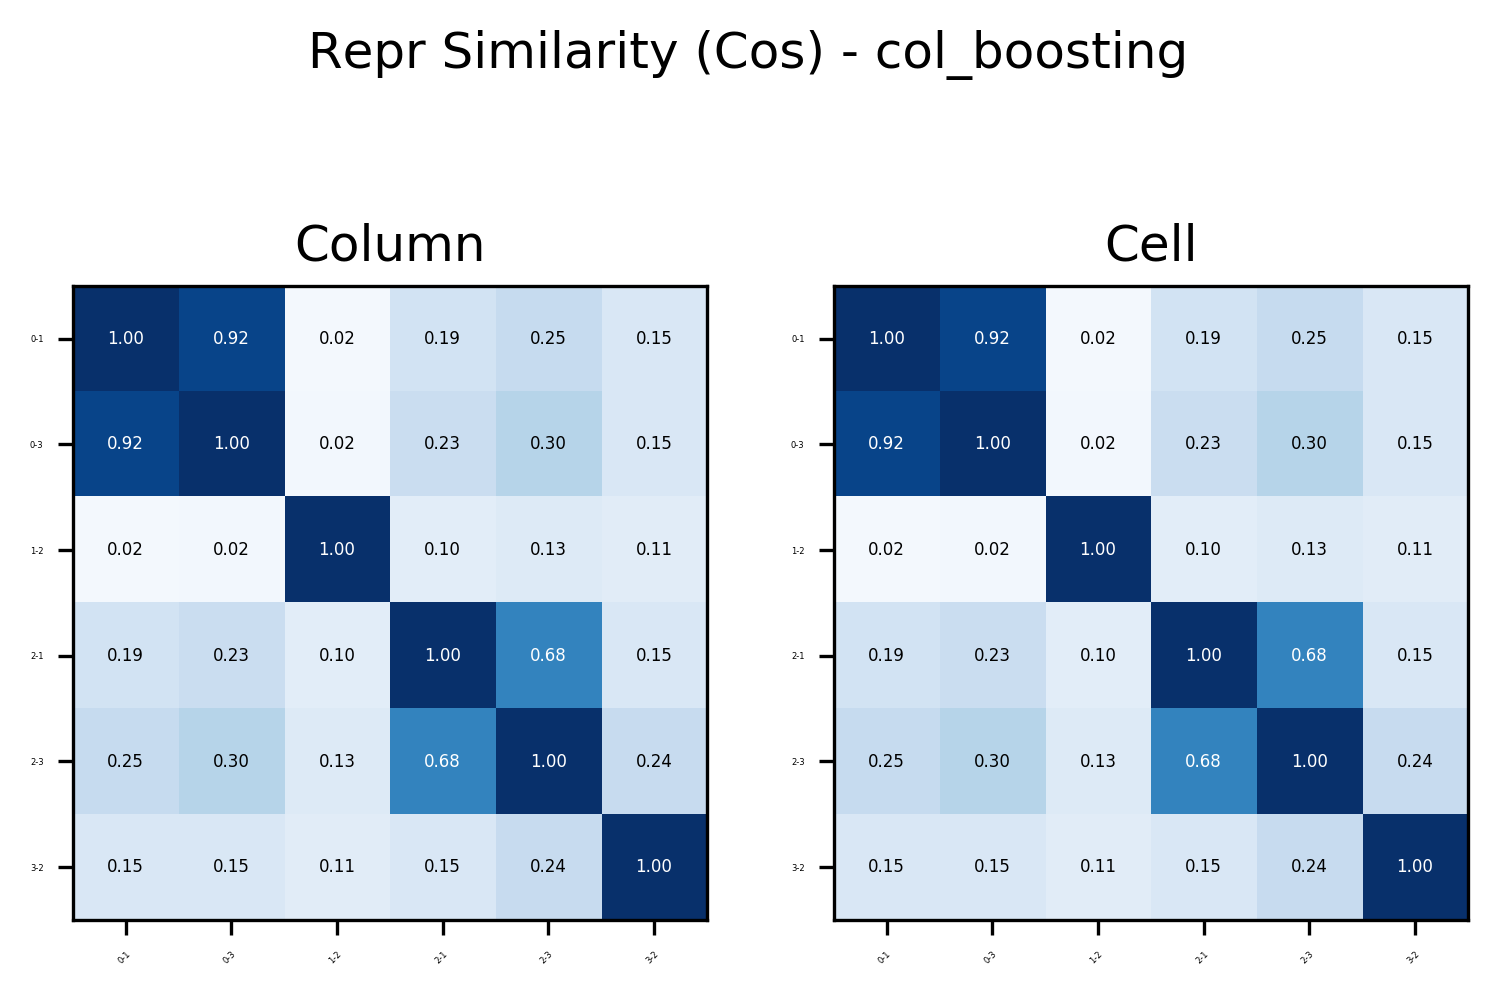

In [355]:
from util import plot_representation_similarity, plot_activity

x_b = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
phi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
psi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
hidden = (x_b, phi, psi)

# model._register_hooks()

for epoch in range(EPOCHS):
    total_loss = 0.0
    all_xb = []
    condtl_column_dists = {}
    last_out = None
    for i, (data, targets, pred_targets, input_labels) in enumerate(loader):

        hidden = _repackage_hidden(hidden)
        optimizer.zero_grad()
        
        out, hidden = model(data, hidden)
        x_b, phi, psi = hidden
        for _x_b, label, target in zip(x_b, input_labels, pred_targets):
            digit = label.item()
            next_digit = target.item()
            activity = _x_b.detach().view(m, -1)
            key = "%d-%d" % (digit, next_digit)
            if key not in condtl_column_dists:
                condtl_column_dists[key] = []
            condtl_column_dists[key].append(activity)
        
        all_xb.append(x_b)
        loss = None
        if predict_memory:
            # Loss computed between x^A generated at last time step and actual x^B
            if last_out is not None:
                loss = criterion(last_out.squeeze(), x_b.detach())
        else:
            loss = criterion(out, targets)
        
        if loss is not None:
            total_loss += loss.item()
            loss.backward()
        
#             _plot_grad_flow(model.named_parameters())
#             plt.show()
            optimizer.step()
        
        last_out = out
        
        if i >= MAX_BATCHES - 1:
            break
    
    if epoch % plot_interval == 0:
        x_b_mean = torch.cat(all_xb).mean().item()
        print(epoch, 'loss', total_loss / (i+1), 'x_b (mean)', x_b_mean)
        plot_representation_similarity(condtl_column_dists, n_labels=4, 
                                       title=model.boost_strat,
                                       fontsize=4)
        plt.show()
#         plot_activity(condtl_column_dists, n_labels=4, level='cell')

In [ ]:
a = torch.randn(2, 12).reshape(2, 4, 3)
print(a)
values, indices = torch.topk(a, 2)
print(indices)
arr = a.new_zeros(a.size())  # Zeros, conserve device
arr.scatter_(2, indices, 1)

In [160]:
import rsm_samplers
reload(rsm_samplers)

sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, 
                                            batch_size=5,
                                            randomize_sequences=True, 
                                            random_mnist_images=True)

loader = DataLoader(dataset,
             batch_sampler=sampler,
             collate_fn=rsm_samplers.pred_sequence_collate)

for i in range(10):
    inp_img, tgt_img, tgt_lab, inp_lab = next(iter(loader))
    print('inp', inp_lab)
#     fig, axs = plt.subplots(1, 2)
#     axs[0].imshow(inp_img[0].view(28, 28))
#     axs[1].imshow(tgt_img[0].view(28, 28))
#     plt.show()

inp tensor([2, 3, 1, 1, 0])
inp tensor([3, 2, 2, 0, 3])
inp tensor([0, 3, 3, 3, 2])
inp tensor([1, 0, 0, 2, 1])
inp tensor([2, 1, 1, 1, 0])
inp tensor([3, 2, 2, 0, 3])
inp tensor([0, 3, 3, 3, 2])
inp tensor([1, 0, 0, 2, 1])
inp tensor([2, 3, 3, 1, 0])
inp tensor([3, 2, 2, 0, 1])


In [114]:
torch.FloatTensor(10).uniform_(0, 1)

tensor([0.0690, 0.0369, 0.7151, 0.8275, 0.9006, 0.3970, 0.0524, 0.5339, 0.4100,
        0.2030])

In [ ]:
from torch.nn.functional import softmax

def topk_mask(a, k, dim=0, do_softmax=False):
    """
    Return a 1 for the top b elements in the last dim of a, 0 otherwise
    """
    if do_softmax:
        return softmax(a)
    else:
        values, indices = torch.topk(a, k)
    arr = a.new_zeros(a.size())  # Zeros, conserve device
    arr.scatter_(dim, indices, 1)
    return arr

a = torch.randn((3, 4))
print(a)
topk_mask(a, 1, dim=1, do_softmax=True)

In [ ]:
from torch import nn
from copy import deepcopy
import matplotlib.pyplot as plt

class LocalLinear(nn.Module):
    """
    """
    def __init__(self, in_features, local_features, kernel_size, stride=1, bias=True):
        super(LocalLinear, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

        fold_num = (in_features - self.kernel_size) // self.stride + 1
        self.lc = nn.ModuleList([deepcopy(nn.Linear(kernel_size, local_features, bias=bias))
                                 for _ in range(fold_num)])

    def forward(self, x):
        x = x.unfold(-1, size=self.kernel_size, step=self.stride)
        fold_num = x.shape[1]
        x = torch.cat([self.lc[i](x[:, i, :]) for i in range(fold_num)], 1)
        return x


class ActiveDendriteLayer(torch.nn.Module):
    """
    Local layer for active dendrites. Similar to a non-shared weight version of a 
    2D Conv layer.
    
    Note that dendrites are fully connected to input, local layer used only for connecting
    neurons and their dendrites
    """
    def __init__(self, input_dim, n_cells=50, n_dendrites=3):
        super(ActiveDendriteLayer, self).__init__()
        self.n_cells = n_cells
        self.n_dendrites = n_dendrites
        
        total_dendrites = n_dendrites * n_cells
        self.linear_dend = nn.Linear(input_dim, total_dendrites)
        self.linear_neuron = LocalLinear(total_dendrites, 1, n_dendrites, stride=n_dendrites)
        
    def __repr__(self):
        return "ActiveDendriteLayer neur=%d, dend per neuron=%d" % (self.n_cells, self.n_dendrites)
    
    def forward(self, x):
        x = F.relu(self.linear_dend(x))
        x = self.linear_neuron(x)
        return x
 
x = torch.randn(1, 5)
print(x)
adl = ActiveDendriteLayer(5, 4, 2)
print(adl(x))


In [ ]:
x = torch.randn(5, 3)
x[:, -2:] = 1
print(x)

In [ ]:
class BitwiseWordEmbedding(object):

    def __init__(self, vocab_size=10000, dim=28):
        self.vocab_size = vocab_size
        self.embedding_dict = {}
        self.dim = dim

    def generate_embeddings(self):
        for i in range(self.vocab_size):
            self.embedding_dict[i] = self.embed(i)

    def embed(self, i):
        first = "{0:b}".format(i).zfill(self.dim // 2)
        return first + self.inverse(first)

    def inverse(self, binstr):
        return ''.join('1' if x == '0' else '0' for x in binstr)

bwe = BitwiseWordEmbedding()

bwe.embed(9381)

In [ ]:
from importlib import reload 
import viz_util
reload(viz_util)

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO
import io
import numpy as np
import matplotlib.pyplot as plt


ax, fig = viz_util.plot_confusion_matrix(np.array([1,2,3]), np.array([1,2,0]), ['0', '1', '2', '3'])

img = viz_util.fig2img(fig)

print(img.shape)
plt.imsave('test.png', img, format='png')


In [ ]:
torch.range(0, 5).expand((3, 6)).t()

In [ ]:
from nupic.torch.functions import KWinners

kw = KWinners.apply

bsz = 2
m = 5
n = 3

k = 2

a = torch.rand(bsz, m, n)
print(a)
kw(a.view(bsz * m, n), 0, k, 0).view(bsz, m, n) > 0


In [ ]:
sl = 2
bsz = 3
m = 5
n = 4
d_in = 10

x = torch.rand((sl, bsz, d_in))

x_a = x[0, :]  # first item

A = torch.nn.Linear(d_in, m)

u = A(x_a)
print(u, u.size())
z = u.repeat_interleave(n, 1)

print(z)

first_z_batch = z[1]
print(first_z_batch.view(m, n))

In [ ]:
import timeit

import rsm_k_winners
reload(rsm_k_winners)

def run_kwin(size=50, scatter=True):
    return rsm_k_winners.KWinners.apply(torch.rand(size, size), 0, 10, 0, scatter)


In [ ]:
run_kwin()

In [ ]:
from timeit import Timer

t = Timer(lambda: run_kwin(scatter=True))
print('scatter', t.timeit(number=10000))

t = Timer(lambda: run_kwin(scatter=False))
print('no_scatter', t.timeit(number=10000))

In [ ]:
import rsm_k_winners
reload(rsm_k_winners)

a = torch.rand(3, 3)

print(a)

res_scatter = rsm_k_winners.KWinners.apply(a.clone(), 0, 2, 0, True)
res_no_scatter = rsm_k_winners.KWinners.apply(a.clone(), 0, 2, 0, False)

print(res_scatter)
print(res_no_scatter)
bool(torch.all(torch.eq(res_scatter, res_no_scatter)).item())

In [ ]:
import numpy as np
import torch


def generate_subsequences(start_digits=[0, 1], digits=10, length=4):
    seq = torch.zeros(digits, length)
    reps = int(np.ceil(digits / len(start_digits)))
    first_col = torch.repeat_interleave(torch.tensor(start_digits), reps, 0)
    seq[:, 0] = first_col[:digits]
    for i in range(1, length):
        column = torch.arange(digits)
        idxs = torch.randperm(digits)
        seq[:, i] = column[idxs]
    print(seq)


generate_subsequences(digits=10)

In [ ]:
inputs = torch.rand(sl, bs, 28**2)

x_b = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
phi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
psi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
hidden = (x_b, phi, psi)

del model 
model = torch.jit.load("/Users/jgordon/nta/results/rsm_jit.pt")

# print(model.graph)

inputs, targets, pred_target, input_label = next(iter(loader))

out, hidden, x_bs = model(inputs, hidden)
print(out.size(), len(hidden), x_bs.size())
total_loss = 0.0
loss = criterion(out, targets)
loss.backward()
total_loss += loss.item()
optimizer.step()
print(out, total_loss)

In [ ]:
a = torch.zeros(5)

torch.max(a.sum(), torch.Tensor(1)).values